In [3]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import os
import sys
import glob
import time
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args



In [4]:
# 导入数据

data = pd.read_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/input/final_data_input_important_16869.csv')
# C:/Jiqiang/jh_z/jh_z/model training_pc/final_data_input_important.csv
# /Users/jiqiang/Nutstore Files/DULT/小论文/第一篇小论文/数据/jh_z/model training_pc_20230521/final_data_input_important.csv
df= pd.DataFrame(data)
counts = df['label'].value_counts()
num_zeros = counts[0]
num_ones = counts[1]
print("number of zero:",num_zeros)
print("number of one:",num_ones)

df


number of zero: 14402
number of one: 2466


,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
1,1,1.036179,0.173910,0.540058,1452.270984,3.351578,2289.101516,7.397089,1
2,2,1.034249,0.173900,0.540413,1427.899396,3.355286,2170.271564,7.548316,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
4,4,1.038104,0.173915,0.539721,1472.312893,3.421316,2262.551560,9.006661,1
...,...,...,...,...,...,...,...,...,...
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0
16866,17500,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220,0


In [5]:
# 从总数据中抽取1000个1和1000个0作为训练和测试，剩下的作为预测集
# 随机抽取label为0和1的数据各1000个
df1 = pd.concat([df[df['label']==0].sample(n=1000),df[df['label']==1].sample(n=1000)]) # 训练集和测试集
print(df1)

# 删除已经抽取的数据，剩下的放入df2中
df2 = df.drop(df1.index) # 剩下的数据作为预测集
df2


        FID_  average_max_rainfall  average_2hr_rainfall   
9172    9415              0.950297              0.163394  \
13838  14286              1.061763              0.168173   
15601  16140              1.002307              0.171399   
6798    7000              0.922200              0.153359   
6640    6840              0.965077              0.171199   
...      ...                   ...                   ...   
378      383              1.047865              0.173819   
10339  10615              0.952340              0.163650   
2878    2957              1.022319              0.170961   
12878  13261              1.078386              0.168591   
11086  11386              1.017153              0.168353   

       average_72hr_rainfall  distance to coast        EV          TWI   
9172                0.553919         803.483054  2.102087  2542.917325  \
13838               0.595141         448.898319  2.634927  1528.803883   
15601               0.569749          37.313387  2.553351

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
1,1,1.036179,0.173910,0.540058,1452.270984,3.351578,2289.101516,7.397089,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
4,4,1.038104,0.173915,0.539721,1472.312893,3.421316,2262.551560,9.006661,1
5,5,1.031257,0.173902,0.540960,1400.698530,3.587869,1970.089000,5.458872,1
...,...,...,...,...,...,...,...,...,...
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0
16866,17500,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220,0


In [6]:
# 固定训练集、测试集、预测集，将其分别输出到CSV文件中
df1.to_csv('train_test_data.csv', index=False)
df2.to_csv('predict_data.csv', index=False)

In [7]:
# 用df1中的数据划分训练集和测试集，输出到CSV文件中，随后分别为训练集和测试集输入特征进行标准化
from sklearn.model_selection import train_test_split

# 提取最后一列并命名为“y”
Y = df1.iloc[:, -1]
Y.name = 'y'


X_train_orgin, X_test_orgin, Y_train_orgin, Y_test_orgin = train_test_split(df1.drop('label', axis=1), df1['label'], test_size=0.2, random_state=42)

# 输出训练集和测试集
X_train_Y_train = pd.concat([X_train_orgin, Y_train_orgin],axis=1)
X_test_Y_test = pd.concat([X_test_orgin, Y_test_orgin],axis=1)

X_train_Y_train.to_csv('train_data.csv', index=False)
X_test_Y_test.to_csv('test_data.csv', index=False)

# 训练集和测试集的特征标准化
from sklearn.preprocessing import StandardScaler


# 提取除最后一列和第一列单元名以外的所有列并命名为“X”
X_train_orgin_dropFID = X_train_orgin.iloc[:, 1:]
X_test_orgin_dropFID = X_test_orgin.iloc[:, 1:]
X_pred = df2.iloc[:, 1:-1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orgin_dropFID)
X_test_scaled = scaler.transform(X_test_orgin_dropFID)
X_pred_scaled = scaler.transform(X_pred)

# 将标准化后的数据输出到新的数据框中
X_train = pd.DataFrame(X_train_scaled, columns=X_train_orgin_dropFID.columns, index=X_train_orgin_dropFID.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_orgin_dropFID.columns,  index=X_test_orgin_dropFID.index)
X_pred = pd.DataFrame(X_pred_scaled, columns=X_pred.columns, index=X_pred.index)

Y_train = Y_train_orgin
Y_test = Y_test_orgin

In [8]:
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.491542,0.914791,-0.998269,2.039478,0.878774,1.183870,1.079815
1,0.562691,0.915741,-1.035396,2.168038,0.778699,1.502696,0.996225
3,0.634175,0.916826,-1.068212,2.255151,0.919892,1.468593,2.034392
4,0.598340,0.916441,-1.053260,2.217157,0.849858,1.469737,2.173725
5,0.471539,0.914495,-0.987661,2.041641,1.019804,1.106682,-0.421698
...,...,...,...,...,...,...,...
16863,-0.605800,0.900126,-0.075680,-0.683682,-0.119009,-0.102737,-0.358624
16864,-0.621797,0.894789,-0.080634,-0.651368,-0.015211,-0.067506,1.016522
16865,-0.571451,0.908038,-0.060041,-0.796371,-0.446888,-0.233863,0.443838
16866,-0.541832,0.913843,-0.044970,-0.841186,-0.426643,-0.362752,0.204040


In [9]:
X_pred_scaled

array([[ 0.49154175,  0.91479142, -0.99826942, ...,  0.87877432,
         1.18387044,  1.07981491],
       [ 0.5626914 ,  0.91574082, -1.03539599, ...,  0.77869939,
         1.50269574,  0.9962254 ],
       [ 0.63417528,  0.91682598, -1.06821219, ...,  0.91989156,
         1.46859258,  2.03439225],
       ...,
       [-0.57145054,  0.90803813, -0.0600414 , ..., -0.44688774,
        -0.23386293,  0.44383787],
       [-0.54183202,  0.91384348, -0.04497028, ..., -0.42664295,
        -0.36275218,  0.20404046],
       [ 1.07001203,  1.1454947 ,  0.58713632, ...,  0.34706991,
         2.35205184, -1.1486383 ]])

In [10]:
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.491542,0.914791,-0.998269,2.039478,0.878774,1.183870,1.079815
1,0.562691,0.915741,-1.035396,2.168038,0.778699,1.502696,0.996225
3,0.634175,0.916826,-1.068212,2.255151,0.919892,1.468593,2.034392
4,0.598340,0.916441,-1.053260,2.217157,0.849858,1.469737,2.173725
5,0.471539,0.914495,-0.987661,2.041641,1.019804,1.106682,-0.421698
...,...,...,...,...,...,...,...
16863,-0.605800,0.900126,-0.075680,-0.683682,-0.119009,-0.102737,-0.358624
16864,-0.621797,0.894789,-0.080634,-0.651368,-0.015211,-0.067506,1.016522
16865,-0.571451,0.908038,-0.060041,-0.796371,-0.446888,-0.233863,0.443838
16866,-0.541832,0.913843,-0.044970,-0.841186,-0.426643,-0.362752,0.204040


In [11]:
X_train_orgin

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1825,1866,0.920949,0.177154,0.560650,14.097288,2.135780,67.204200,4.171712
3598,3715,0.954092,0.172947,0.556438,125.542949,2.720312,369.839650,4.329534
2789,2865,0.913962,0.166292,0.549716,165.510367,1.851444,502.656363,5.004086
664,675,1.044793,0.172184,0.536613,1864.005099,4.740313,2423.960408,5.104832
3057,3139,1.032857,0.167085,0.537063,1378.394819,3.852363,2004.564590,7.180330
...,...,...,...,...,...,...,...,...
3312,3421,0.916397,0.167846,0.551544,4.731770,0.751195,22.328130,5.049193
15974,16525,1.007576,0.170645,0.590247,896.502770,1.483650,1665.959646,5.001589
8880,9123,1.034457,0.164522,0.553416,638.821068,3.449693,1260.501421,4.864089
2285,2339,0.911149,0.176939,0.560858,88.158399,0.552942,277.908407,6.666321


In [12]:
X_train_orgin_dropFID

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1825,0.920949,0.177154,0.560650,14.097288,2.135780,67.204200,4.171712
3598,0.954092,0.172947,0.556438,125.542949,2.720312,369.839650,4.329534
2789,0.913962,0.166292,0.549716,165.510367,1.851444,502.656363,5.004086
664,1.044793,0.172184,0.536613,1864.005099,4.740313,2423.960408,5.104832
3057,1.032857,0.167085,0.537063,1378.394819,3.852363,2004.564590,7.180330
...,...,...,...,...,...,...,...
3312,0.916397,0.167846,0.551544,4.731770,0.751195,22.328130,5.049193
15974,1.007576,0.170645,0.590247,896.502770,1.483650,1665.959646,5.001589
8880,1.034457,0.164522,0.553416,638.821068,3.449693,1260.501421,4.864089
2285,0.911149,0.176939,0.560858,88.158399,0.552942,277.908407,6.666321


In [13]:
X_train_scaled

array([[-1.57102275,  1.38522683,  0.05426195, ..., -0.46185983,
        -1.25550753, -1.36333409],
       [-0.95730957,  0.77632826, -0.16861344, ...,  0.13457734,
        -0.87982406, -1.24787758],
       [-1.70039842, -0.18702065, -0.52435483, ..., -0.75198614,
        -0.71494899, -0.75440198],
       ...,
       [ 0.53079394, -0.44313692, -0.32855691, ...,  0.87881272,
         0.22581939, -0.8568184 ],
       [-1.75249546,  1.35411328,  0.06525515, ..., -2.07693453,
        -0.99394502,  0.46162356],
       [ 0.13869965,  0.41534767,  1.68751812, ..., -1.58720648,
         1.53538173,  0.19817906]])

In [14]:
X_train

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
1825,-1.571023,1.385227,0.054262,-1.356721,-0.461860,-1.255508,-1.363334
3598,-0.957310,0.776328,-0.168613,-1.083583,0.134577,-0.879824,-1.247878
2789,-1.700398,-0.187021,-0.524355,-0.985629,-0.751986,-0.714949,-0.754402
664,0.722194,0.665883,-1.217708,3.177139,2.195718,1.670106,-0.680700
3057,0.501167,-0.072249,-1.193915,1.986978,1.289684,1.149479,0.837653
...,...,...,...,...,...,...,...
3312,-1.655307,0.037908,-0.427609,-1.379674,-1.874644,-1.311215,-0.721403
15974,0.033048,0.443183,1.620461,0.805929,-1.127271,0.729144,-0.756229
8880,0.530794,-0.443137,-0.328557,0.174388,0.878813,0.225819,-0.856818
2285,-1.752495,1.354113,0.065255,-1.175208,-2.076935,-0.993945,0.461624


In [15]:
X_test

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
8813,-0.522925,0.601982,0.233073,0.291746,0.027850,0.809225,0.236788
3242,-0.667161,0.832349,-0.137825,-1.044438,0.089291,-0.649975,-1.079693
776,-0.592716,1.170580,-0.385835,-0.436866,0.807947,0.284109,-0.513095
9258,-0.228887,0.675194,0.350027,0.118470,-0.079911,0.714435,0.053264
16757,1.643602,1.447505,0.828118,-0.485014,-0.303022,0.339362,-0.474010
...,...,...,...,...,...,...,...
15134,-1.612187,-0.334001,0.316186,-0.575149,0.059879,0.050177,-0.876317
16349,-1.854439,2.985070,1.695823,-1.169026,-1.256791,-0.857321,-1.180859
1968,-2.015287,1.553206,0.180664,-1.213805,-1.844989,-0.986059,-0.451968
11796,0.016832,0.457521,0.409970,0.439036,0.676867,-0.056034,0.109850


In [16]:
Y_train

1825     0
3598     0
2789     0
664      0
3057     0
        ..
3312     1
15974    1
8880     0
2285     1
15927    1
Name: label, Length: 1600, dtype: int64

In [17]:
Y_test

8813     1
3242     0
776      1
9258     0
16757    1
        ..
15134    0
16349    1
1968     1
11796    0
2680     0
Name: label, Length: 400, dtype: int64

In [18]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print(pd.value_counts(Y_train))

print(pd.value_counts(Y_test))

(1600, 7) (400, 7) (1600,) (400,)
label
0    801
1    799
Name: count, dtype: int64
label
1    201
0    199
Name: count, dtype: int64


In [19]:
def print_test_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def print_train_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_train) == Y_train)/len(Y_train)))
    time.sleep(0.5) # to let the print get out before any progress bars
shap.initjs()

In [33]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 将数据分为X_train, Y_train, X_test, Y_test

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier()

# 定义参数空间
param_grid = {
    'max_depth': [3, 4, 6, 8,10],
    'learning_rate': [0.2,0.1, 0.01, 0.05],
    # 'min_child_weight': [1, 3, 5,7,10],
    # 'subsample': [0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1],
    # 'gamma': [0, 0.1,0.3, 0.5],
    'n_estimators': [50, 100],
}

# 定义5折交叉验证策略
cv = StratifiedKFold(n_splits=5)

# 使用GridSearchCV进行自动调参和交叉验证
grid_search_xgb = GridSearchCV(xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=-1)

grid_search_xgb.fit(X_train, Y_train)

# 输出每一折的训练集和测试集准确率
for i in range(5):
    print("Fold ", i+1)
    train_index, test_index = list(cv.split(X_train, Y_train))[i]
    print("Training Accuracy: ", accuracy_score(Y_train.iloc[train_index], grid_search_xgb.predict(X_train.iloc[train_index])))
    print("Testing Accuracy: ", accuracy_score(Y_train.iloc[test_index], grid_search_xgb.predict(X_train.iloc[test_index])))

# 输出模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线平均值
print("Training Accuracy: ", accuracy_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing Accuracy: ", accuracy_score(Y_test, grid_search_xgb.predict(X_test)).round(3))
print("Training Precision: ", precision_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing Precision: ", precision_score(Y_test, grid_search_xgb.predict(X_test)).round(3))
print("Training Recall: ", recall_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing Recall: ", recall_score(Y_test, grid_search_xgb.predict(X_test)).round(3))
print("Training F1 Score: ", f1_score(Y_train, grid_search_xgb.predict(X_train)).round(3))
print("Testing F1Score: ", f1_score(Y_test, grid_search_xgb.predict(X_test)).round(3))

# 计算ROC曲线和AUC曲线
fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_xgb.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_xgb.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# 输出ROC曲线和AUC曲线平均值
print("Training ROC AUC: ", roc_auc_train.round(3))
print("Testing ROC AUC: ", roc_auc_test.round(3)) 

Fold  1
Training Accuracy:  0.8453125
Testing Accuracy:  0.834375
Fold  2
Training Accuracy:  0.83828125
Testing Accuracy:  0.8625
Fold  3
Training Accuracy:  0.840625
Testing Accuracy:  0.853125
Fold  4
Training Accuracy:  0.8546875
Testing Accuracy:  0.796875
Fold  5
Training Accuracy:  0.83671875
Testing Accuracy:  0.86875
Training Accuracy:  0.843
Testing Accuracy:  0.762
Training Precision:  0.851
Testing Precision:  0.768
Training Recall:  0.831
Testing Recall:  0.756
Training F1 Score:  0.841
Testing F1Score:  0.762
Training ROC AUC:  0.929
Testing ROC AUC:  0.848


In [24]:
# nn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 定义多层感知机模型
mlp = MLPClassifier()

# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (10, 10)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# 定义5折交叉验证器
cv = StratifiedKFold(n_splits=5)

# 定义网格搜索器
grid_search_mlp = GridSearchCV(mlp, param_grid=param_grid,
                           cv=cv, scoring='roc_auc')

# 训练模型并进行自动调参
grid_search_mlp.fit(X_train, Y_train)

# 输出最佳参数组合和对应的AUC值
print('Best parameters:', grid_search_mlp.best_params_)
print('Best AUC:', grid_search_mlp.best_score_)

# 计算模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线等指标，并打印结果
Y_train_pred = grid_search_mlp.predict(X_train)
Y_test_pred = grid_search_mlp.predict(X_test)

print('Training accuracy:', accuracy_score(Y_train, Y_train_pred))
print('Testing accuracy:', accuracy_score(Y_test, Y_test_pred))

print('Training precision:', precision_score(Y_train, Y_train_pred))
print('Testing precision:', precision_score(Y_test, Y_test_pred))

print('Training recall:', recall_score(Y_train, Y_train_pred))
print('Testing recall:', recall_score(Y_test, Y_test_pred))

print('Training F1 score:', f1_score(Y_train, Y_train_pred))
print('Testing F1 score:', f1_score(Y_test, Y_test_pred))

fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_mlp.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_mlp.predict_proba(X_test)[:, 1])

print('Training AUC:', auc(fpr_train, tpr_train))
print('Testing AUC:', auc(fpr_test, tpr_test))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Best AUC: 0.8440612346917848
Training accuracy: 0.79
Testing accuracy: 0.745
Training precision: 0.7971758664955071
Testing precision: 0.7487437185929648
Training recall: 0.7772215269086358
Testing recall: 0.7412935323383084
Training F1 score: 0.7870722433460077
Testing F1 score: 0.745
Training AUC: 0.8616341588033731
Testing AUC: 0.8383209580239507


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [1]:
# LR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd

# 定义逻辑回归模型和参数网格
model = LogisticRegression()
param_grid = {'C': [ 0.01, 0.1,1]}

# 使用GridSearchCV进行自动调参和5折交叉验证
grid_search_lr = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train, Y_train)

# 打印最佳参数和最佳得分
print('Best Parameters:', grid_search_lr.best_params_)
print('Best Score:', grid_search_lr.best_score_)

# 在训练集上评估模型
Y_train_pred = grid_search_lr.predict(X_train)
print('Training Accuracy:', accuracy_score(Y_train, Y_train_pred))
print('Training Precision:', precision_score(Y_train, Y_train_pred))
print('Training Recall:', recall_score(Y_train, Y_train_pred))
print('Training F1 Score:', f1_score(Y_train, Y_train_pred))

# 在测试集上评估模型
Y_test_pred = grid_search_lr.predict(X_test)
print('Testing Accuracy:', accuracy_score(Y_test, Y_test_pred))
print('Testing Precision:', precision_score(Y_test, Y_test_pred))
print('Testing Recall:', recall_score, Y_test_pred)
print('Testing F1 Score:', f1_score(Y_test, Y_test_pred))

# 绘制ROC曲线和计算AUC
fpr, tpr, thresholds = roc_curve(Y_test, grid_search_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'X_train' is not defined

比较三个代表性模型的性能，如果相差很大，那就不用再加RF, SVM,如果相差不大，加上。
多个模型和多个可解释性的比较分析，用预测正确的结果进行可解释性分析。


In [34]:
# 将LR, XGB, NN的模型性能进行对比

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc

# 训练三个机器学习模型并预测测试集
model_lr = grid_search_lr
model_xgb = grid_search_xgb
model_mlp = grid_search_mlp

Y_test_pred1 = model_lr.predict(X_test)
Y_test_pred2 = model_xgb.predict(X_test)
Y_test_pred3 = model_mlp.predict(X_test)

# 计算评价指标
accuracy_train1 = accuracy_score(Y_train, model_lr.predict(X_train))
accuracy_train2 = accuracy_score(Y_train, model_xgb.predict(X_train))
accuracy_train3 = accuracy_score(Y_train, model_mlp.predict(X_train))

accuracy_test1 = accuracy_score(Y_test, model_lr.predict(X_test))
accuracy_test2 = accuracy_score(Y_test, model_xgb.predict(X_test))
accuracy_test3 = accuracy_score(Y_test, model_mlp.predict(X_test))

precision_train1 = precision_score(Y_train, model_lr.predict(X_train))
precision_train2 = precision_score(Y_train, model_xgb.predict(X_train))
precision_train3 = precision_score(Y_train, model_mlp.predict(X_train))

precision_test1 = precision_score(Y_test, Y_test_pred1)
precision_test2 = precision_score(Y_test, Y_test_pred2)
precision_test3 = precision_score(Y_test, Y_test_pred3)

recall_train1 = recall_score(Y_train, model_lr.predict(X_train))
recall_train2 = recall_score(Y_train, model_xgb.predict(X_train))
recall_train3 = recall_score(Y_train, model_mlp.predict(X_train))

recall_test1 = recall_score(Y_test, Y_test_pred1)
recall_test2 = recall_score(Y_test, Y_test_pred2)
recall_test3 = recall_score(Y_test, Y_test_pred3)

f1score_train1 = f1_score(Y_train, model_lr.predict(X_train))
f1score_train2 = f1_score(Y_train, model_xgb.predict(X_train))
f1score_train3 = f1_score(Y_train, model_mlp.predict(X_train))

f1score_test1 = f1_score(Y_test, Y_test_pred1)
f1score_test2 = f1_score(Y_test, Y_test_pred2)
f1score_test3 = f1_score(Y_test, Y_test_pred3)

# 将评价指标存储在字典中
results_train = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (train)': [accuracy_train1, accuracy_train2, accuracy_train3],
    'Precision (train)': [precision_train1, precision_train2, precision_train3],
    'Recall (train)': [recall_train1, recall_train2, recall_train3],
    'F1 score (train)': [f1score_train1, f1score_train2, f1score_train3],
}
results_test = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (test)': [accuracy_test1, accuracy_test2, accuracy_test3],
    'Precision (test)': [precision_test1, precision_test2, precision_test3],
    'Recall (test)': [recall_test1, recall_test2, recall_test3],
    'F1 score (test)': [f1score_test1, f1score_test2, f1score_test3],
}
# 将字典转换为 Pandas 数据框
df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)

# 打印结果
print(df_results_train)
print(df_results_test)

       Model  Accuracy (train)  Precision (train)  Recall (train)   
0   Model_lr          0.783125           0.803763        0.748436  \
1  Model_xgb          0.843125           0.851282        0.831039   
2  Model_mlp          0.790000           0.797176        0.777222   

   F1 score (train)  
0          0.775113  
1          0.841039  
2          0.787072  
       Model  Accuracy (test)  Precision (test)  Recall (test)   
0   Model_lr           0.7450          0.748744       0.741294  \
1  Model_xgb           0.7625          0.767677       0.756219   
2  Model_mlp           0.7450          0.748744       0.741294   

   F1 score (test)  
0         0.745000  
1         0.761905  
2         0.745000  


In [35]:
df_results_train

,Model,Accuracy (train),Precision (train),Recall (train),F1 score (train)
0,Model_lr,0.783125,0.803763,0.748436,0.775113
1,Model_xgb,0.843125,0.851282,0.831039,0.841039
2,Model_mlp,0.790000,0.797176,0.777222,0.787072


In [36]:
df_results_test

,Model,Accuracy (test),Precision (test),Recall (test),F1 score (test)
0,Model_lr,0.7450,0.748744,0.741294,0.745000
1,Model_xgb,0.7625,0.767677,0.756219,0.761905
2,Model_mlp,0.7450,0.748744,0.741294,0.745000


xgb_loss 0.4816336129191123
linear_loss 0.550481871053267
dnn_loss 9.191131614224874

xgb_roc_auc 0.8483587089677243
linear_roc_auc 0.8189704742618567
dnn_roc_auc 0.7450186254656366

xgb_pr_auc 0.8638224824505027
linear_pr_auc 0.8151434686936309
dnn_pr_auc 0.6850388759718993



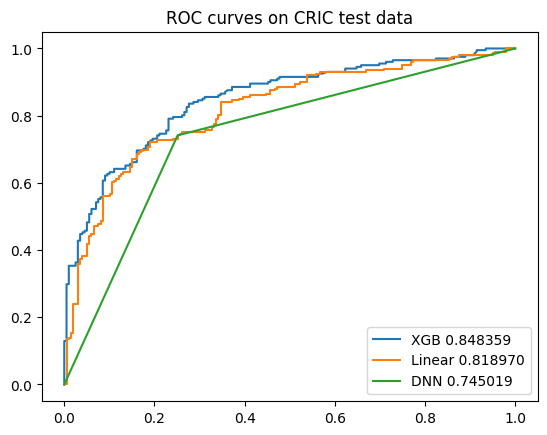

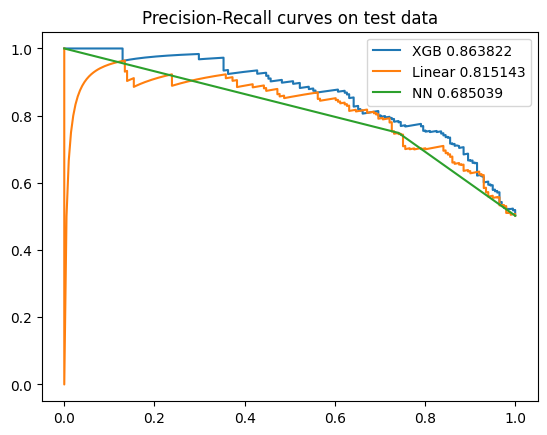

In [37]:
# Compute performance metrics
Y_test1 = Y_test.ravel() # 将Y_test1转换为一维数组
xgb_loss = sklearn.metrics.log_loss(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_loss = sklearn.metrics.log_loss(Y_test1, model_lr.predict_proba(X_test)[:,1])
nn_loss = sklearn.metrics.log_loss(Y_test1, model_mlp.predict(X_test))
# constant_loss = sklearn.metrics.log_loss(Y_test1, np.zeros(len(Y_test1)) * y_strain.mean())
print("xgb_loss", xgb_loss)
print("linear_loss", linear_loss)
print("dnn_loss", nn_loss)
print()

xgb_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_mlp.predict(X_test))
#svm_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_roc_auc", xgb_roc_auc)
print("linear_roc_auc", linear_roc_auc)
print("dnn_roc_auc", dnn_roc_auc)
#print("svm_roc_auc", svm_roc_auc)
print()

xgb_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_mlp.predict(X_test))
#svm_pr_auc = sklearn.metrics.average_precision_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_pr_auc", xgb_pr_auc)
print("linear_pr_auc", linear_pr_auc)
print("dnn_pr_auc", dnn_pr_auc)
#print("svm_pr_auc", svm_pr_auc)
print()

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_mlp.predict(X_test))
#svm_fpr, svm_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, svm_model.predict_proba(X_test))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_roc_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_roc_auc)
pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_roc_auc)
#pl.plot(svm_fpr, svm_tpr, label="SVM %f" % svm_roc_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")
pl.show()

xgb_prec, xgb_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_prec, linear_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_prec, dnn_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_mlp.predict(X_test))
#svm_prec, svm_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, svm_model.predict_proba(X_test))

pl.plot(xgb_recall, xgb_prec, label="XGB %f" % xgb_pr_auc)
pl.plot(linear_recall, linear_prec, label="Linear %f" % linear_pr_auc)
pl.plot(dnn_recall, dnn_prec, label="NN %f" % dnn_pr_auc)
#pl.plot(svm_recall, svm_prec, label="SVM %f" % svm_pr_auc)
pl.legend()
pl.title("Precision-Recall curves on test data")
pl.show()

### 将三个模型预测准确的样本选出来分别放入一个样本集中，用于后续可解释性方法对比分析
1. 用训练好的模型预测剩余样本
2. 将所有样本（训练集、测试集、预测集）预测概率与是否预测正确输出，并于样本编号匹配
3. 挑选出预测正确的样本
4. 用不同可解释性方法对不同模型预测正确的样本进行可解释性分析

In [ ]:
X_train_orgin

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
16222,16779,1.049907,0.168794,0.557996,1129.889503,3.662467,2255.010078,5.742475
8521,8760,1.030456,0.166262,0.554642,884.389714,3.271473,1518.635023,5.522590
15352,15866,1.010183,0.170970,0.588249,883.283815,3.428352,1311.209166,6.065288
4342,4469,1.039167,0.162994,0.540616,423.032404,3.093332,415.010002,4.705822
15324,15837,1.023857,0.170286,0.594285,164.874177,1.070095,622.495900,7.137646
...,...,...,...,...,...,...,...,...
10131,10403,1.030044,0.170952,0.563003,333.033251,2.290530,574.086358,7.931736
15593,16132,1.032253,0.170500,0.596371,154.315681,1.327678,568.651734,4.734017
760,773,1.059307,0.174226,0.536926,1390.640338,4.359947,2394.214195,4.811757
9744,10003,1.033008,0.165231,0.554992,449.098707,2.469748,568.980120,5.601915


In [ ]:
X_train

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
16222,0.809721,0.173597,-0.049484,1.364486,1.073710,1.434431,-0.187149
8521,0.438820,-0.200942,-0.233291,0.758543,0.671680,0.528996,-0.351752
15352,0.052245,0.495509,1.608568,0.755813,0.832987,0.273948,0.054505
4342,0.604914,-0.684353,-1.002045,-0.380179,0.488511,-0.828004,-0.963176
15324,0.312975,0.394279,1.939391,-1.017365,-1.591836,-0.572883,0.857261
...,...,...,...,...,...,...,...
10131,0.430966,0.492780,0.224916,-0.602315,-0.336952,-0.632407,1.451708
15593,0.473075,0.425938,2.053702,-1.043426,-1.326983,-0.639089,-0.942070
760,0.988960,0.977077,-1.204249,2.008071,1.790879,1.605595,-0.883874
9744,0.487478,-0.353484,-0.214127,-0.315842,-0.152675,-0.638685,-0.292371


In [ ]:
df2

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,1.032337,0.173904,0.540760,1399.816133,3.449655,2032.268709,7.511351,1
2,2,1.034249,0.173900,0.540413,1427.899396,3.355286,2170.271564,7.548316,1
3,3,1.040040,0.173918,0.539438,1487.814834,3.489952,2261.629379,8.816202,1
4,4,1.038104,0.173915,0.539721,1472.312893,3.421316,2262.551560,9.006661,1
5,5,1.031257,0.173902,0.540960,1400.698530,3.587869,1970.089000,5.458872,1
...,...,...,...,...,...,...,...,...,...
16862,17496,0.935459,0.191556,0.553047,342.628301,3.359726,1080.673409,5.261832,0
16863,17497,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090,0
16864,17498,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834,0
16865,17499,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009,0


In [ ]:
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0.474679,0.929422,-0.994147,2.030718,0.854892,1.160552,1.137013
2,0.511135,0.928919,-1.013142,2.100033,0.757858,1.330238,1.164684
3,0.621560,0.931501,-1.066588,2.247917,0.896326,1.442570,2.113809
4,0.584658,0.931108,-1.051102,2.209655,0.825753,1.443704,2.256385
5,0.454081,0.929120,-0.983161,2.032896,0.997007,1.084097,-0.399450
...,...,...,...,...,...,...,...
16862,-1.372627,3.540585,-0.320730,-0.578632,0.762424,-0.009515,-0.546952
16863,-0.655339,0.914435,-0.038612,-0.711711,-0.150579,-0.113837,-0.334909
16864,-0.671812,0.908980,-0.043743,-0.679168,-0.045981,-0.078941,1.072247
16865,-0.619966,0.922521,-0.022415,-0.825197,-0.480983,-0.243718,0.486232


In [38]:
# 将训练、测试、预测结果与输入一起保存到output文件中
# 训练集
output_train_lr = pd.concat([X_train_orgin, Y_train_orgin, pd.Series(model_lr.predict_proba(X_train)[:,1], index=X_train_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
outpt_train_xgb = pd.concat([X_train_orgin, Y_train_orgin, pd.Series(model_xgb.predict_proba(X_train)[:,1], index=X_train_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_train_mlp = pd.concat([X_train_orgin, Y_train_orgin, pd.Series(model_mlp.predict_proba(X_train)[:,1], index=X_train_orgin.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 测试集
output_test_lr = pd.concat([X_test_orgin, Y_test_orgin, pd.Series(model_lr.predict_proba(X_test)[:,1], index=X_test_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_xgb = pd.concat([X_test_orgin, Y_test_orgin, pd.Series(model_xgb.predict_proba(X_test)[:,1], index=X_test_orgin.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_mlp = pd.concat([X_test_orgin, Y_test_orgin, pd.Series(model_mlp.predict_proba(X_test)[:,1], index=X_test_orgin.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 预测集
output_pred_lr = pd.concat([df2, pd.Series(model_lr.predict_proba(X_pred)[:,1], index=df2.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_xgb = pd.concat([df2, pd.Series(model_xgb.predict_proba(X_pred)[:,1], index=df2.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_mlp = pd.concat([df2, pd.Series(model_mlp.predict_proba(X_pred)[:,1], index=df2.index, name='probability_1')], axis=1) # 保留预测为1的概率


# predicted列为预测结果，0为未被淹，1为被淹
# 训练集
output_train_lr['predicted'] = (output_train_lr['probability_1'] >= 0.5).astype(int)
outpt_train_xgb['predicted'] = (outpt_train_xgb['probability_1'] >= 0.5).astype(int)
output_train_mlp['predicted'] = (output_train_mlp['probability_1'] >= 0.5).astype(int)

# 测试集
output_test_lr['predicted'] = (output_test_lr['probability_1'] >= 0.5).astype(int)
output_test_xgb['predicted'] = (output_test_xgb['probability_1'] >= 0.5).astype(int)
output_test_mlp['predicted'] = (output_test_mlp['probability_1'] >= 0.5).astype(int)

# 预测集
output_pred_lr['predicted'] = (output_pred_lr['probability_1'] >= 0.5).astype(int)
output_pred_xgb['predicted'] = (output_pred_xgb['probability_1'] >= 0.5).astype(int)
output_pred_mlp['predicted'] = (output_pred_mlp['probability_1'] >= 0.5).astype(int)


# 判断预测是否正确
# 训练集
output_train_lr['correct'] = (output_train_lr['predicted'] == output_train_lr['label']).astype(int)
outpt_train_xgb['correct'] = (outpt_train_xgb['predicted'] == outpt_train_xgb['label']).astype(int)
output_train_mlp['correct'] = (output_train_mlp['predicted'] == output_train_mlp['label']).astype(int)

# 测试集
output_test_lr['correct'] = (output_test_lr['predicted'] == output_test_lr['label']).astype(int)
output_test_xgb['correct'] = (output_test_xgb['predicted'] == output_test_xgb['label']).astype(int)
output_test_mlp['correct'] = (output_test_mlp['predicted'] == output_test_mlp['label']).astype(int)

# 预测集
output_pred_lr['correct'] = (output_pred_lr['predicted'] == output_pred_lr['label']).astype(int)
output_pred_xgb['correct'] = (output_pred_xgb['predicted'] == output_pred_xgb['label']).astype(int)
output_pred_mlp['correct'] = (output_pred_mlp['predicted'] == output_pred_mlp['label']).astype(int)

# 将预测正确的样本保存在output文件中
# 训练集
output_train_lr_correct = output_train_lr[output_train_lr['correct'] == 1]
outpt_train_xgb_correct = outpt_train_xgb[outpt_train_xgb['correct'] == 1]
output_train_mlp_correct = output_train_mlp[output_train_mlp['correct'] == 1]

# 测试集
output_test_lr_correct = output_test_lr[output_test_lr['correct'] == 1]
output_test_xgb_correct = output_test_xgb[output_test_xgb['correct'] == 1]
output_test_mlp_correct = output_test_mlp[output_test_mlp['correct'] == 1]

# 预测集
output_pred_lr_correct = output_pred_lr[output_pred_lr['correct'] == 1]
output_pred_xgb_correct = output_pred_xgb[output_pred_xgb['correct'] == 1]
output_pred_mlp_correct = output_pred_mlp[output_pred_mlp['correct'] == 1]

# 保存到CSV文件中
# 测试集
output_train_lr_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_train_lr_correct.csv', index=False)
outpt_train_xgb_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_train_xgb_correct.csv', index=False)
output_train_mlp_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_train_mlp_correct.csv', index=False)

# 测试集
output_test_lr_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_test_lr_correct.csv', index=False)
output_test_xgb_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_test_xgb_correct.csv', index=False)
output_test_mlp_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_test_mlp_correct.csv', index=False)

# 预测集
output_pred_lr_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/output_pred_mlp_correct.csv', index=False)

# 将测试集、训练集、预测集结果预测正确的样本保存在一个文件中
output_pred_lr_correct_all = pd.concat([output_train_lr_correct, output_test_lr_correct, output_pred_lr_correct], axis=0)
output_pred_xgb_correct_all = pd.concat([outpt_train_xgb_correct, output_test_xgb_correct, output_pred_xgb_correct], axis=0)
output_pred_mlp_correct_all = pd.concat([output_train_mlp_correct, output_test_mlp_correct, output_pred_mlp_correct], axis=0)

# 保存到CSV文件中
output_pred_lr_correct_all.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/all_output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct_all.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/all_output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct_all.to_csv('/workspaces/Interpretable_ML_UFSM/Interpretable_ML_for_UFSM/output/all_output_pred_mlp_correct.csv', index=False)




In [ ]:
# TREESHAP

# 指标1 runtime 解释1000个预测样本所需的时间

# 指标2 local accuracy 1000个样本中，与模型输出的差异的归一化标准偏差

# 指标3 Consistency guarantees 一致性保证是解释方法的一个理论属性，它确保成对的案例永远一致（属性2）。我们把对这一属性的同意分成三个不同的类别：确切的保证、在无限抽样情况下成立的保证和没有保证。

# 指标4 Keep positive (mask) 指标衡量的是解释方法找到使模型输出增加最多的特征的能力。增加模型输出最多的特征。对于一个单一的输入，最积极的输入特征被保留在它们的原始值上，而所有其他的输入特征被掩盖在它们的平均值上。
# github库 Captum


In [ ]:
# KernelSHAP

In [ ]:
# Individual Conditional Expectation (ICE) https://github.com/AustinRochford/PyCEbox

In [ ]:
# Counterfactual Explanations https://github.com/interpretml/DiCE

In [ ]:
# LIME GitHub代码找到 https://github.com/marcotcr/lime

In [ ]:
# saabas可以加上,nmL那篇文章都加了，我们也可以加，https://github.com/andosa/treeinterpreter
